### Dataset by:
```
@misc{https://doi.org/10.48550/arxiv.2101.03091,
  doi = {10.48550/ARXIV.2101.03091},  
  url = {https://arxiv.org/abs/2101.03091},  
  author = {Rozemberczki, Benedek and Sarkar, Rik},  
  keywords = {Social and Information Networks (cs.SI), Artificial Intelligence (cs.AI), Machine Learning (cs.LG), FOS: Computer and information sciences, FOS: Computer and information sciences},  
  title = {Twitch Gamers: a Dataset for Evaluating Proximity Preserving and Structural Role-based Node Embeddings},  
  publisher = {arXiv},  
  year = {2021},
  copyright = {Creative Commons Attribution 4.0 International}
}

```
https://arxiv.org/abs/2101.03091

### THE TWITCH GAMERS DATASET
Twitch is a streaming service where users can broadcast live streams
of playing computer games. As users can follow each other there
is an underlying social network which can be accessed through the
public API. In 2018 April we crawled the largest connected component of this social network with snowball sampling starting from
the user called Lowko. We released Twitch Gamers dataset is a
clean subset of the original social network. We filtered out nodes
and edges based on the following principled steps:

(1) No missing attributes. We only kept nodes that have all
of the vertex attributes present.

(2) Mutual relationships. We discarded relationships which
are asymmetric and only included mutual edges in the released dataset.

(3) Member of the largest component. We only considered nodes which are part of the largest connected com-
ponent

*Quelle:* https://arxiv.org/abs/2101.03091

In [128]:
import networkx as nx   
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Netzwerk einlesen und in NetworkX abbilden

In [129]:
# Netzwerk einlesen
fh = open("data/large_twitch_edges.csv", "rb")
G = nx.read_edgelist(fh, delimiter=',')
fh.close()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\IPython\core\interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\vince\AppData\Local\Temp\ipykernel_5000\2417018289.py", line 3, in <cell line: 3>
    G = nx.read_edgelist(fh, delimiter=',')
  File "<class 'networkx.utils.decorators.argmap'> compilation 5", line 5, in argmap_read_edgelist_1
  File "c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\networkx\readwrite\edgelist.py", line 376, in read_edgelist
    return parse_edgelist(
  File "c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\networkx\readwrite\edgelist.py", line 241, in parse_edgelist
    for line in lines:
  File "c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\networkx\readwrite\edgelist.py", line 375, in <genexpr>
    lines = (line if isinstance(line, str) else line.decode(encoding) for line in path)
KeyboardInterrupt

During handling of the above except

In [ ]:
# Remove header nodes
G.remove_node('numeric_id_1')
G.remove_node('numeric_id_2')

### Manuelle Überprüfung, ob das Netz korrekt eingelesen wurde

In [ ]:
edge_list = pd.read_csv('data/large_twitch_edges.csv').astype(str)
edge_list.head()

,numeric_id_1,numeric_id_2
0,98343,141493
1,98343,58736
2,98343,140703
3,98343,151401
4,98343,157118


In [ ]:
# Überprüfung, ob die Nachbarn von 98343 korrekt abgebildet wurden.
assert set(G.neighbors('98343')) == set(edge_list[edge_list.numeric_id_1=='98343'].numeric_id_2), "Neighbors of 98343 are not correctly displayed in the Network."

## EDA auf Knotenattributen und Netzwerkgrösse
### Netzwerkgrösse

In [ ]:
print(f'Anzahl Knoten: {G.number_of_nodes()}')
print(f'Anzahl Kanten: {G.number_of_edges()}')
print(f'Density: {nx.density(G)}')

Anzahl Knoten: 168114
Anzahl Kanten: 6797557
Density: 0.00048103610439398153


Wir haben es also mit einem sehr grossen Netzwerk zu tun, welches aber wenig Kanten hat im Vergleich mit der Anzahl Knoten. Dies ergibt soweit Sinn, da eine Kante nur entsteht, wenn sich User gegenseitig followen. User, welche fast nur anderen zuschauen, werden wohl wenig Kanten haben, da diese eher selten gefollowed werden. Wir werden das Netzwerk nach gewissen Knotenattributen filtern, um die Prozessierung zu ermöglichen. 

Für dieses Projekt werden wir affiliate, Partner und gepartnete User als Synonym verwenden. Ebenfalls gehört jeder Channel einem User, somit kann das Wort User/Channel als fast identisch angesehen werden. Für einen Stream geht man auf Twitch "zu einem User" und nicht "einem Channel, welcher von einem User erstellt wurde". Ein Benutzer kann also nicht einen zweiten Channel erstellen mit seinem User.

### Knotenattribute

In [ ]:
features = pd.read_csv('data/large_twitch_features.csv')
features.numeric_id = features.numeric_id.astype(str)
# Cast boolean ints to booleans for more beautiful plots
for col in features.columns:
    if set([0, 1]) == set(features[col]):
        features[col] = features[col].astype(bool)

# Cast datetime cols to datetime
features.created_at = pd.to_datetime(features.created_at)
features.updated_at = pd.to_datetime(features.updated_at)

In [ ]:
features.sample(5)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
55367,4335,True,1491,2014-09-08,2018-10-08,55367,False,EN,True
127237,4127,True,788,2016-08-14,2018-10-11,127237,False,EN,True
62438,1354,True,1238,2015-05-23,2018-10-12,62438,False,EN,False
166470,174588,False,2774,2011-02-20,2018-09-25,166470,False,EN,True
109569,19,False,165,2018-04-03,2018-09-15,109569,False,EN,False


Der Datensatz hat folgende Attribute:
- `views`: Anzahl Views auf dem User / Channel
- `mature`: Ob der Channel sich an Erwachsene richtet.
- `life_time`: Anzahl Tage zwischen erstem Stream und letztem Stream.
- `created_at`: Wann der User erstellt wurde
- `updated_at`: Wann der User das letzte mal gestreamed hat.
- `numeric_id`: Unique ID des Users
- `dead_account`: Ob der Account deaktiviert wurde oder der User lange nicht aktiv war (~3 Monate)
- `language`: Sprache des Users / Channel
- `affiliate`: Ob der User ein Twitch-Partner (affiliate) ist oder nicht (nicht-Partner)

Wir können uns ein paar Attribute genauer anschauen:

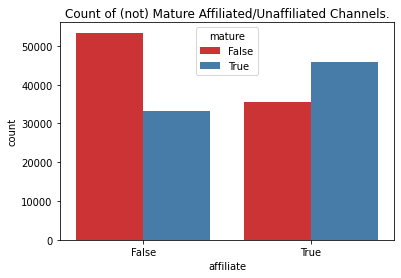

In [ ]:
sns.countplot(data=features, x="affiliate", hue="mature", palette="Set1")
plt.title('Count of (not) Mature Affiliated/Unaffiliated Channels.')
plt.show()

Wir sehen also, dass mature Channels weniger oft gepartnert sind als nicht-mature Channels.

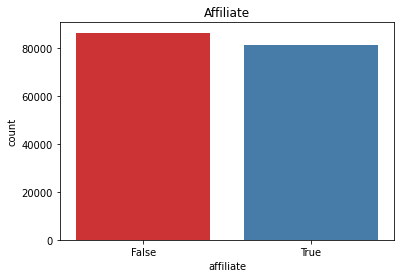

In [ ]:
sns.countplot(data=features, x="affiliate", palette="Set1")
plt.title('Affiliated vs Unaffiliated')
plt.show()

Es hat überraschend viele gepartnete User mit Twitch. Ich hätte nicht gedacht, dass das Verhältniss fast 50/50 ist.

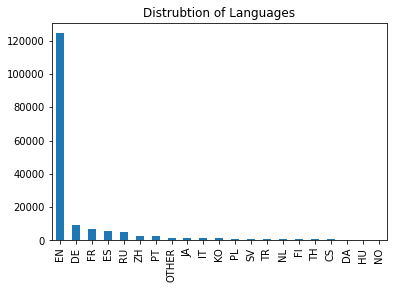

In [ ]:
features.language.value_counts().plot(kind='bar', title='Distrubtion of Languages')
plt.show()

Überwiegend ist die Channelsprache Englisch, gefolgt (weit abgeschlagen) von Deutsch, Französisch, Spanisch und Russisch. 

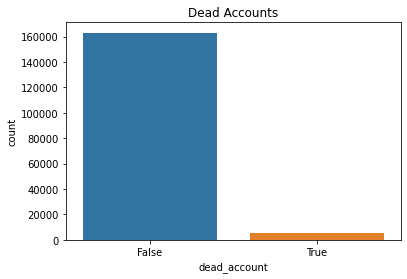

In [ ]:
sns.countplot(data=features, x="dead_account")
plt.title('Dead Accounts')
plt.show()

Interessant zu sehen, dass es nur sehr wenige, inaktive User gibt. Es wäre eine Untersuchung wert, ob das vielleicht aus der Art, wie die Daten gesammelt wurden, entstanden ist (e.g., das nur aktive Accounts und ihre Follower in gescrapped wurden).

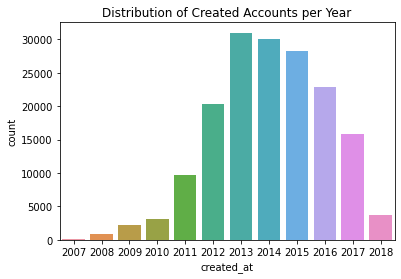

In [ ]:
sns.countplot(x=features.created_at.dt.year)
plt.title('Distribution of Created Accounts per Year')
plt.show()

In diesem Plot sieht man deutlich die Jahre, wo Twitch stark zugelegt hat (2011-2016).

Im vorherigen Abschnitt haben wir die Annahme getroffen, dass Twitch-Partner mehr Kanten haben als nicht-Partner. Wir können uns dafür die Density von den zwei Subgruppen anschauen.

In [ ]:
netzwerk_partner = nx.subgraph(G, features[features.affiliate==True].numeric_id.tolist())
netzwerk_kein_partner = nx.subgraph(G, features[features.affiliate==False].numeric_id.tolist())

In [ ]:
print(f'Density von Nicht-Partnern: {nx.density(netzwerk_kein_partner)}')
# Density nimmt general ab mit der Grösse des Netzwerks
# Metrik, welche diese berücksichtigt.

Density von Nicht-Partnern: 0.0006154880996428399


In [ ]:
print(f'Density von Partnern: {nx.density(netzwerk_partner)}')

Density von Partnern: 0.0004175468251946277


Das war nicht erwartet; Die Density von nicht-Partnern ist ca. 50% höher als von Partnern. Dies bedeutet, dass sich nicht-Partnern gegenseitiger häufiger folgen als Partner. Ändern sich diese Zahlen, wenn wir inaktive Accounts rausnehmen?

In [ ]:
netzwerk_aktiv = nx.subgraph(G, features[features.dead_account==False].numeric_id.tolist())
netzwerk_aktiv_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==True].numeric_id.tolist())
netzwerk_aktiv_kein_partner = nx.subgraph(netzwerk_aktiv, features[features.affiliate==False].numeric_id.tolist())

In [ ]:
print(f'Density von aktiven Nicht-Partnern: {nx.density(netzwerk_aktiv_kein_partner)}')

Density von aktiven Nicht-Partnern: 0.0006735701234769484


In [ ]:
print(f'Density von aktiven Partnern: {nx.density(netzwerk_aktiv_partner)}')

Density von aktiven Partnern: 0.00041792783234412354


Die Density nimmt zu, bei beiden, aber mehr bei den nicht-Partnern. Ergibt auch Sinn, da Partner wohl im Prinzip nicht inaktiv sein können. Dies lässt sich leicht überprüfen in einer Grafik:

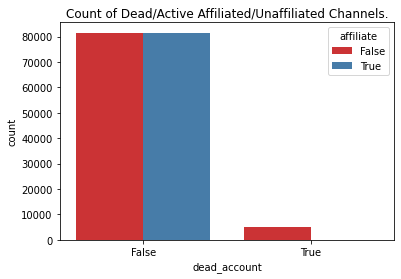

In [ ]:
sns.countplot(data=features, x="dead_account", hue="affiliate", palette="Set1")
plt.title('Count of Dead/Active Affiliated/Unaffiliated Channels.')
plt.show()

Man sieht aber deutlich, dass die Anzahl von gepartnerten Accounts, welche inaktiv sind, verschwindent gering ist. Das sieht aber fast nach einem Fehler aus. Wie kann die Ratio von gepartnetern Usern von aktiven Accounts fast identisch sein? Ist da was falsch? 

In [ ]:
print(f"Anteil Partner von inaktiven vs aktiven User:\n{features.groupby('dead_account')['affiliate'].value_counts()}")

Anteil Partner von inaktiven vs aktiven User:
dead_account  affiliate
False         False        81483
              True         81472
True          False         5085
              True            74
Name: affiliate, dtype: int64


Nein, die zwei Zahlen sind fast identisch. Es ist aber trotzdem unerwartet, dass sich nicht-Partner gegenseitig häufiger folgen als Partner.

#### Views
Wir schauen uns nun das Attribut `views` an von aktiven Accounts, separat für Partner und nicht-Partner.

In [ ]:
active_accounts = features[features.dead_account==False]
views_active_no_partner = active_accounts[active_accounts.affiliate==False].views
views_active_partner = active_accounts[active_accounts.affiliate==True].views

In [ ]:
# Print mean and median for views of active accounts without partner and with partner
print(f"Mean views of active accounts without partner: {views_active_no_partner.mean():.2f}")
print(f"Mean views of active accounts with partner: {views_active_partner.mean():.2f}")
print(f"Median views of active accounts without partner: {views_active_no_partner.median():.2f}")
print(f"Median views of active accounts with partner: {views_active_partner.median():.2f}")

Mean views of active accounts without partner: 364752.97
Mean views of active accounts with partner: 23299.74
Median views of active accounts without partner: 1945.00
Median views of active accounts with partner: 7469.00


Sehr interessant! Wieder unerwartet. Im Durchschnitt hat ein Partner ca. 15x mehr Views als nicht-Partner. Wenn wir uns aber den Median anschauen, ist das Bild anders; hier hat ein Partner ca. 4x soviele Views. Es scheint so, als hätten nicht-Partner massive Aussreisser in den Views. Dies können wir mit einem Boxplot bestätigen:

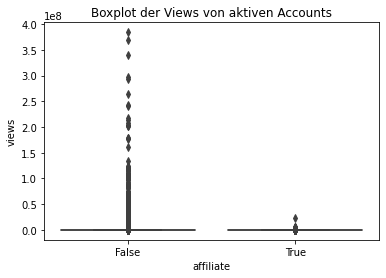

In [ ]:
sns.boxplot(x='affiliate', y='views', data=active_accounts)
plt.title('Boxplot der Views von aktiven Accounts')
plt.show()

Wir können uns noch die Top 30 anschauen und sehen, dass von den Top 30 Views niemand gepartnert ist mit Twitch.

In [ ]:
active_accounts.sort_values(by='views', ascending=False).head(30)

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
96473,384396587,False,2416,2012-03-01,2018-10-12,96473,False,RU,False
129896,368912220,False,2379,2012-04-07,2018-10-12,129896,False,EN,False
61862,340602050,False,2826,2011-01-16,2018-10-12,61862,False,EN,False
128864,297117159,False,2314,2012-06-11,2018-10-12,128864,False,EN,False
144643,294116493,False,2577,2011-09-22,2018-10-12,144643,False,EN,False
110345,264643346,False,2664,2011-06-27,2018-10-12,110345,False,EN,False
125642,243451177,False,2507,2011-12-01,2018-10-12,125642,False,EN,False
64605,240718261,True,2516,2011-11-22,2018-10-12,64605,False,EN,False
71050,218559516,False,2169,2012-11-03,2018-10-12,71050,False,EN,False
161362,213931993,False,2359,2012-04-27,2018-10-12,161362,False,EN,False


Eine gute Erklärung habe ich dafür nicht, es wäre aber Möglich, über das Datum der Usererstellung ein Mapping zu machen zwischen der uniquen ID und dem richtigen Namen und dann mehr herausfinden zu können, warum die Channels mit den meisten User von nicht-Partnern sind.

Beispiel [Tyler1](https://twitchtracker.com/loltyler1):

- Tyler1 hat seinen User am 14.11.2013 erstellt.
- Er spricht Englisch.
- Er hatte Ende 2018 mehr als 80 Millionen Views.


Wir können nun nach diesem User filtern:

In [ ]:
active_accounts[
    (active_accounts.created_at=='2013-11-14') &
    (active_accounts.language=='EN') &
    (active_accounts.views > 80000000)
    ]

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
6250,84804681,True,1793,2013-11-14,2018-10-12,6250,False,EN,False


Somit entspricht die `numeric_id` 6250 wohl Tyler1. Gewisse Sachen haben sich aber geändert: Jetzt ist der Channel von Tyler1 nicht mehr an Erwachsene gerichtet. Ebenfalls war er Ende 2018 nicht Partner. Ich kann mich aber erinnern, dass Tyler1 [gebannt](https://web.archive.org/web/20190417084311/https://support.riotgames.com/hc/en-us/articles/115013815928-Understanding-ID-Bans) wurde in diesem Zeitrahmen (~2017/18) und danach wurde sein Account wieder freigeschaltet, hat aber wahrscheinlich seinen Partner-Status verloren. 

Warum die meistgesehenen Channels aber nicht gepartnert sind, bleibt eine offene Frage. 

Hier lässt sich aber auch die Annahme treffen, dass in den Daten ein Fehler passiert ist und beim Knotenatttribut `affiliated` 1 und 0 verwechselt wurde. Es ist sehr unwahrscheinlich, dass keiner der Top 30 meistgesehenen User mit Twitch gepartnert ist. Ggf. muss man also gewisse Analysen im EDA-Teil anders interpretieren.

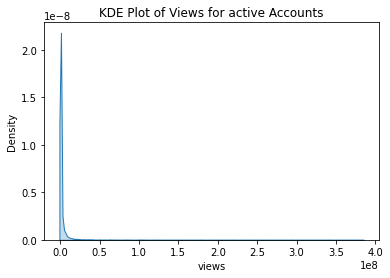

In [ ]:
sns.kdeplot(active_accounts.views, shade=True)
plt.title('KDE Plot of Views for active Accounts')
plt.show()

In [ ]:
# Quantiles
active_accounts.views.quantile([0.25, 0.5, 0.75, 0.99])

0.25       1515.00
0.50       4336.00
0.75      14848.50
0.99    2676764.08
Name: views, dtype: float64

Wir sehen, dass die meiste Density von Views in einem KDEPlot für alle aktiven Accounts in einem sehr kleinen Bereich liegt. 25% der User haben weniger als 1515 Views auf ihrem Channel und 50% weniger als 4336. Wir sehen auch, dass wir gegen oben (>99 Perzentil) es unglaubliche Ausreisser gibt, welche unseren Density Plot verziehen.

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


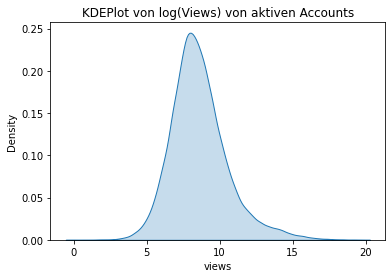

In [ ]:
sns.kdeplot(np.log(active_accounts.views), shade=True)
plt.title('KDEPlot von log(Views) von aktiven Accounts')
plt.show()

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


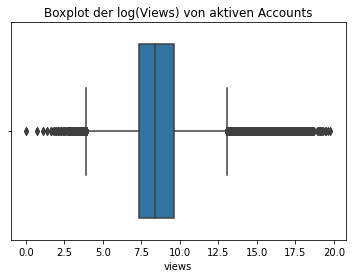

In [ ]:
sns.boxplot(x=np.log(active_accounts.views))
plt.title('Boxplot der log(Views) von aktiven Accounts')
plt.show()

c:\Users\vince\anaconda3\envs\SAN\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


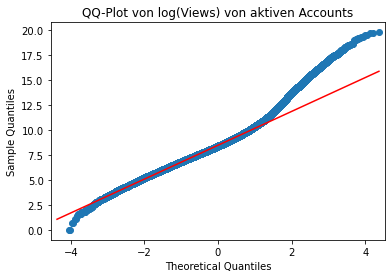

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

fig = sm.qqplot(np.log(active_accounts.views), line='q')
plt.title('QQ-Plot von log(Views) von aktiven Accounts')
plt.show()

Die Verteilung der Views scheint eine `lognorm`-Verteilung zu sein, mit massiven Aussreissern gegen oben hin (long-tail gegen rechts). Dies sehen wir auch im QQ-Plot von `log(views)`. 

### Degree Centrality

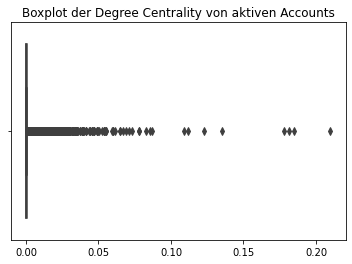

In [ ]:
# Degree Centrality
degree_centrality = nx.degree_centrality(G)
sns.boxplot(x=list(degree_centrality.values()))
plt.title('Boxplot der Degree Centrality von aktiven Accounts')
plt.show()

In [ ]:
np.quantile(list(degree_centrality.values()), [0.90, 0.9999])

array([0.00096364, 0.06533704])

Die Degree Centrality zeigt, dass 90% der User mit weniger als 0.0000096% mit anderen User verbunden sind durch gegenseitiges followen. Man sieht aber auch, dass ein User mit mehr als 20% aller User verbunden ist. 

In [ ]:
# Find the top 10 nodes with the highest degree centrality
sorted_degree_centrality = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
sorted_degree_centrality[:1]

[('61862', 0.2098528965636209)]

Wir können schauen, wer das sein könnte.

In [ ]:
features[features.numeric_id=='61862']

,views,mature,life_time,created_at,updated_at,numeric_id,dead_account,language,affiliate
61862,340602050,False,2826,2011-01-16,2018-10-12,61862,False,EN,False


[Ninja](https://twitchtracker.com/ninja) hat seinen Account am 16.1.2011 erstellt und er ist einer der meistgeschauten Streamer auf Twitch. Man kann also annehmen, dass er `61862` ist.

In [ ]:
# Get number of neighbor for Ninja (most connected node)
for node, degree in sorted_degree_centrality[:1]:
    print(f'Node: {node}, Degree: {degree}')
    # Number of neighbor
    print(f'Number of neighbors: {G.degree(node)}')

Node: 61862, Degree: 0.2098528965636209
Number of neighbors: 35279


Dies ist schon erstaunlich. Kann dies wirklich sein, dass Ninja 20% der User auf Twitch folgt (35279 User)? Vielleicht bedeutet `mutual relationship` etwas anderes? Zitat aus dem Paper von Twitch Gamers:
```
Mutual relationships. We discarded relationships which
are asymmetric and only included mutual edges in the re-
leased dataset.
```
Ich bin mir unsicher. Es kann ja nicht sein, dass `Ninja` 20% der User auf Twitch folgt. 

Andererseits schauen wir uns in diesem Datensatz ja nicht ganz Twitch an, sondern nur ein Subset. Auf [TwitchTracker](https://twitchtracker.com/statistics) sehen wir, dass es in 2018 im Schnitt 1.08 Millionen Zuschauer gab. Somit schauen wir uns mit 168'114 Knoten auch nur einen Bruchteil von Twitch an. 

In [ ]:
# Get number of neighbor for nodes with the least degree centrality
for node, degree in sorted_degree_centrality[-5:]:
    print(f'Node: {node}, Degree: {degree}')
    # Number of neighbor
    print(f'Number of neighbors: {G.degree(node)}')

Node: 131422, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 102494, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 157597, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 128281, Degree: 5.948379958718243e-06
Number of neighbors: 1
Node: 118034, Degree: 5.948379958718243e-06
Number of neighbors: 1


Somit haben wir in unserem Datensatz nur User mit:
- mindestens einer Kante (gegenseitiges folgen).
- sind vom User `lowko` über ein Schneeball-System erreichbar.

Es kann also wirklich sein, dass `Ninja` 20% von diesem Subset folgt.

### Degrees

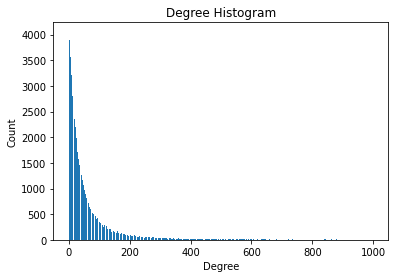

In [169]:
degree = nx.degree_histogram(G)[:1000]
plt.bar(x=range(len(degree)), height=degree)
plt.title('Degree Histogram')
plt.xlabel('Degree')
plt.ylabel('Count')
plt.show()

Die Verteilung der Anzahl der Degrees sieht sehr exponential aus.

### Korrelation Degree und Views
Hat ein User mit vielen Kanten mehr Views?

In [134]:
id_degree_df = pd.DataFrame(G.degree(), columns=['numeric_id', 'degree'])
id_degree_df.head(5)

,numeric_id,degree
0,98343,39
1,141493,4456
2,58736,420
3,140703,242
4,151401,235


In [216]:
try:
    features.drop(columns=['degree_x', 'degree_y'], inplace=True)
    features = pd.merge(features, id_degree_df, on='numeric_id')
except:
    features = pd.merge(features, id_degree_df, on='numeric_id')

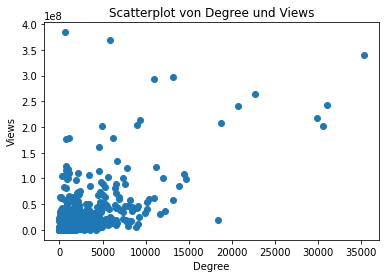

In [217]:
plt.scatter(features['degree'], features['views'])
plt.xlabel('Degree')
plt.ylabel('Views')
plt.title('Scatterplot von Degree und Views')
plt.show()

In [226]:
p_corr = np.corrcoef(features.views, features.degree)[1,0]
print(f'Pearson Korrelation von degree und views: {p_corr:.3f}')

Pearson Korrelation von degree und views: 0.650


In [149]:
from scipy.stats import spearmanr
print(f'Spearman Korrelation von degree und views: {spearmanr(features.views, features.degree)[0]:.3f}')

Pearson Korrelation von degree und views: 0.514


Wieder etwas interessantes gelernt. Laut [StackExchange](https://stats.stackexchange.com/questions/27127/what-does-it-indicate-when-the-spearman-correlation-is-a-definite-amount-less-th) ist die Spearman Korrelation niedriger als die Pearson Korrelation, falls die Rank-Korrelation niedriger ist als die Lineare-Korrelation. Das kann passieren, falls es extreme Ausreisser gibt / einen langen Longtail. Dies ist bei uns der Fall. 
#### Permutationstest
Mit einem Permutationstest können wir schauen, ob diese Pearson Korrelation nur Zufall ist. Wir wählen als `alpha` 0.05. Unsere Nullhypothese ist, dass der `degree` und die Anzahl Views nicht linear miteinander korrelieren. Die Alternativhypothese ist, dass sie miteinander korrelieren.

In [230]:
N_TESTS = 1000

p_corrs = []
corr_same_or_above = 0
for i in range(N_TESTS):
    views = features.views.sample(frac=1, replace=False, random_state=i)
    p_corrs.append(np.corrcoef(views, features.degree)[1,0])
    if p_corrs[-1] > p_corr:
        corr_same_or_above += 1

In [233]:
print(f'p-Wert von Pearson: {corr_same_or_above/N_TESTS}')

p-Wert von Pearson: 0.0


Da der p-Wert kleiner ist als unser `alpha`, verwerfen wir die Nullhypothese und schätzen die Korrelation zwischen Knoten-Degree und Anzahl Views als signifikant ein. 

### Reichweite maximieren, Kosten minimieren
Für unsere fiktive Werbung möchten wir ein möglichst weites Publikum für möglichst kleines Geld erreichen. Es lässt sich also Annehmen, dass neue Streamer mit eher wenig Views günstiger zu kaufen sind und das Streamer mit vielen Kanten eine grosse Reichweite haben. Somit sollten wir folgendes optimieren:
- Degrees maximieren mit Hilfe von Knoten, welche keine oder nur wenig, gleiche Nachbarn haben
- Totale Anzahl Views minimieren.

Da die lineare Korrelation mit 0.650 nicht perfekt ist, können wir einen Algorithmus dafür entwickeln.

In [ ]:
# Feedback: Gute kommentare, gedanken ausschreiben.
# User finden, welche zusammen eine grosse reichweite finden und weniger als x views haben (da zu teuer). Welche Gruppe ergäntzt eine andere am besten ? -> Nach Degree nach unten gehen -> GGf von hinten anfangen? -> Alle weiter unten sind eh wenig views. 
# Erst wenn weniger als x views
# Group centrality. 
# "Kern finden"-> viele views, gegenseitiges followen.
# Degree  und views permuationstest + affiliate.